In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/clolab/Hackathon/"

/content/drive/MyDrive/clolab/Hackathon


# **Thực hiện trên Sheet GDP**
# Bước 1: Lấy dữ liệu sheet GDP từ file

In [3]:
# Import thư viện
from sklearn import linear_model
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 
import seaborn as sns
sns.set_style('whitegrid')
% matplotlib inline

# Lấy dữ liệu dạng Dataframe của sheet GDP từ file dữ liệu 
DATASET_GDP = pd.read_excel('dataset_vongloai.xlsx', sheet_name='GDP')

# Bước 2: Xử lý dữ liệu bị thiếu

In [4]:
#Kiểm tra dữ liệu có bao nhiêu ô dữ liệu bị thiếu (missing values)
DATASET_GDP.isnull().sum()

Nội dung       0
Đơn vị tính    2
Q1/2005        2
Q2/2005        9
6M/2005        2
              ..
6M/2021        2
Q3/2021        2
9M/2021        2
Q4/2021        2
Q1/2022        2
Length: 105, dtype: int64

In [5]:
# Xử lý dữ liệu bị rỗng

# Xoá 2 cột chứa các nhãn dữ liệu như 'Nội dung', 'Đơn vị tính'.
TapDuLieu_GDP = DATASET_GDP.drop(['Nội dung', 'Đơn vị tính'], axis=1)
# Xoá các hàng có toàn giá trị rỗng (hàng "Tăng trưởng GDP thực"
# và "Giá trị GDP hiện tại")
TapDuLieu_GDP = TapDuLieu_GDP.dropna(how='all')
# Tạm thời bỏ dữ liệu của Q1/2022, chỉ chừa lại dữ liệu đầy đủ của các năm
TapDuLieu_GDP = TapDuLieu_GDP.iloc[: , :-1]


# Gán nhãn chiều dữ liệu theo hàng (có tất cả 11 hàng)
TapDuLieu_GDP.set_axis(['1', '2', '3','4','5','6','7','8','9','10','11'],
                        axis='index', inplace=True)

# Thực hiện đảo chiều dữ liệu rồi điền các giá trị rỗng bằng cách nội suy
# từ các giá trị đã biết. (tính trung bình 2 giá trị trước và sau)
TapDuLieu_GDP.T['1']=TapDuLieu_GDP.T['1'].interpolate()
TapDuLieu_GDP.T['2']=TapDuLieu_GDP.T['2'].interpolate()
TapDuLieu_GDP.T['3']=TapDuLieu_GDP.T['3'].interpolate()
TapDuLieu_GDP.T['4']=TapDuLieu_GDP.T['4'].interpolate()
TapDuLieu_GDP.T['5']=TapDuLieu_GDP.T['5'].interpolate()
TapDuLieu_GDP.T['6']=TapDuLieu_GDP.T['6'].interpolate()
TapDuLieu_GDP.T['7']=TapDuLieu_GDP.T['7'].interpolate()

# 4 hàng giá trị thuộc nhóm "Giá trị GDP hiện tại" bị mất đi số liệu
# ở quý 4/2016 (Q4/2016) nên ta sẽ tính bằng cách lấy trung bình của
# quý 4 của năm trước cộng với quý 4 của năm sau ((Q4/2015 + Q4/2017)/2) 

TapDuLieu_GDP.T['8']['Q4/2016'] = (TapDuLieu_GDP.T['8']['Q4/2015']+
                                   TapDuLieu_GDP.T['8']['Q4/2017'])/2
TapDuLieu_GDP.T['9']['Q4/2016'] = (TapDuLieu_GDP.T['9']['Q4/2015']+
                                   TapDuLieu_GDP.T['9']['Q4/2017'])/2
TapDuLieu_GDP.T['10']['Q4/2016'] = (TapDuLieu_GDP.T['10']['Q4/2015']+
                                    TapDuLieu_GDP.T['10']['Q4/2017'])/2
TapDuLieu_GDP.T['11']['Q4/2016'] = (TapDuLieu_GDP.T['11']['Q4/2015']+
                                    TapDuLieu_GDP.T['11']['Q4/2017'])/2

# In ra dữ liệu đã xử lý
print(TapDuLieu_GDP)



      Q1/2005     Q2/2005    6M/2005     Q3/2005   9M/2005    Q4/2005  \
1       15.69      18.900      22.11      21.355      20.6      17.50   
2       43.03      41.410      39.79      40.545      41.3      42.25   
3       41.28      39.690      38.10      38.100      38.1      40.25   
4      107.20     107.415     107.63     107.865     108.1     107.65   
5      104.10     104.165     104.23     104.165     104.1     103.10   
6      108.50     109.000     109.50     109.750     110.0     109.35   
7      107.00     107.300     107.60     107.900     108.2     107.80   
8    25768.00   58301.000   84069.00   37018.000  121087.0   53961.00   
9    70679.00   80655.000  151334.00   90915.000  242249.0  101558.00   
10   67796.00   77070.000  144866.00   78896.000  223762.0   95241.00   
11  164243.00  216026.000  380269.00  206829.000  587098.0  250760.00   

     Q1/2006     Q2/2006    6M/2006     Q3/2006  ...     6M/2020     Q3/2020  \
1       14.4      17.555      20.71      20

In [6]:
#Kiểm tra dữ liệu có còn missing values nữa hay không?
TapDuLieu_GDP.isnull().sum()

Q1/2005    0
Q2/2005    0
6M/2005    0
Q3/2005    0
9M/2005    0
          ..
Q2/2021    0
6M/2021    0
Q3/2021    0
9M/2021    0
Q4/2021    0
Length: 102, dtype: int64

# Bước 3: Trực quan hoá dữ liệu

In [7]:
#Vẽ biểu đồ để tiến hành trực quan hóa dữ liệu
####
import numpy as np
#Lấy dữ liệu theo quý từ tập dữ liệu đã xử lí phía trên.
q1 = np.arange(0, 68, 4 , dtype=int)
q2 = np.arange(1, 68, 4 , dtype=int)
q3 = np.arange(2, 68, 4 , dtype=int)
q4 = np.arange(3, 68, 4 , dtype=int)
#Lấy dữ liệu theo 4 quý giai đoạn 2005 - 2021 của ngành Nông nghiệp 
GDP_NongNghiep_Quy1 = TapDuLieu_GDP.T['8'][q1]
GDP_NongNghiep_Quy2 = TapDuLieu_GDP.T['8'][q2]
GDP_NongNghiep_Quy3 = TapDuLieu_GDP.T['8'][q3]
GDP_NongNghiep_Quy4 = TapDuLieu_GDP.T['8'][q4]
#Lấy dữ liệu theo 4 quý giai đoạn 2005 - 2021 của ngành Công nghiệp 
GDP_CongNghiep_Quy1 = TapDuLieu_GDP.T['9'][q1]
GDP_CongNghiep_Quy2 = TapDuLieu_GDP.T['9'][q2]
GDP_CongNghiep_Quy3 = TapDuLieu_GDP.T['9'][q3]
GDP_CongNghiep_Quy4 = TapDuLieu_GDP.T['9'][q4]
#Lấy dữ liệu theo 4 quý giai đoạn 2005 - 2021 của ngành Dịch vụ
GDP_DichVu_Quy1 = TapDuLieu_GDP.T['10'][q1]
GDP_DichVu_Quy2 = TapDuLieu_GDP.T['10'][q2]
GDP_DichVu_Quy3 = TapDuLieu_GDP.T['10'][q3]
GDP_DichVu_Quy4 = TapDuLieu_GDP.T['10'][q4]
#Lấy dữ liệu theo 4 quý giai đoạn 2005 - 2021 của tổng giá trị GDP 3 ngành
GDP_Tong_Quy1 = TapDuLieu_GDP.T['11'][q1]
GDP_Tong_Quy2 = TapDuLieu_GDP.T['11'][q2]
GDP_Tong_Quy3 = TapDuLieu_GDP.T['11'][q3]
GDP_Tong_Quy4 = TapDuLieu_GDP.T['11'][q4]
#Lấy dữ liệu Tổng GDP của 3 ngành theo năm giai đoạn 2005 - 2021 (4 quý cộng lại)
GDP_Tong_Nam = np.add(GDP_Tong_Quy1.to_numpy(), GDP_Tong_Quy2.to_numpy()) 
GDP_Tong_Nam = np.add(GDP_Tong_Nam,GDP_Tong_Quy3.to_numpy())
GDP_Tong_Nam = np.add(GDP_Tong_Nam,GDP_Tong_Quy4.to_numpy())
 
# Các dòng dữ liệu được đánh thứ tự như sau:
# Nội dung
# 1.Nông nghiệp
# 2.Công nghiệp
# 3.Dịch vụ
# Tăng trưởng GDP thực
# 4.Tổng GDP
# 5.Nông nghiệp
# 6.Công nghiệp
# 7.Dịch vụ
# Giá trị GDP hiện tại
# 8.Nông nghiệp
# 9.Công nghiệp
# 10.Dịch vụ
# 11.Tổng GDP


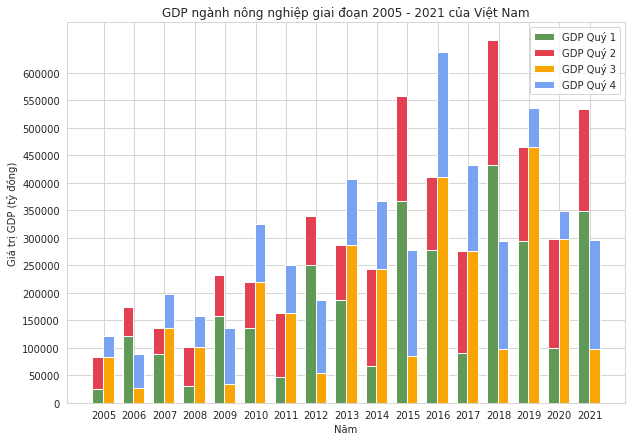

In [8]:
## Biểu đồ GDP ngành nông nghiệp 2005 - 2021 theo 4 quý
import numpy as np
import matplotlib.pyplot as plt

years = list(map(str, range(2005, 2022)))

ind = np.arange(len(GDP_NongNghiep_Quy1)) 
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind - 0.2, GDP_NongNghiep_Quy1, width, color = '#619a56')
p2 = plt.bar(ind - 0.2, GDP_NongNghiep_Quy2, width, color = '#e34051', 
             bottom = GDP_NongNghiep_Quy1)
p3 = plt.bar(ind + 0.15, GDP_NongNghiep_Quy3, width, color = '#f9a504')
p4 = plt.bar(ind + 0.15, GDP_NongNghiep_Quy4, width, color = '#79a2f2',
              bottom = GDP_NongNghiep_Quy3)
plt.ylabel('Giá trị GDP (tỷ đồng)')
plt.xlabel('Năm')
plt.title('GDP ngành nông nghiệp giai đoạn 2005 - 2021 của Việt Nam')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 650000 , 50000)) #Thiết lập giá trị trục y tùy ý vì biểu đồ biểu diễn cho cả 4 quý.
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('GDP Quý 1', 'GDP Quý 2', 'GDP Quý 3', 'GDP Quý 4'))

plt.show()

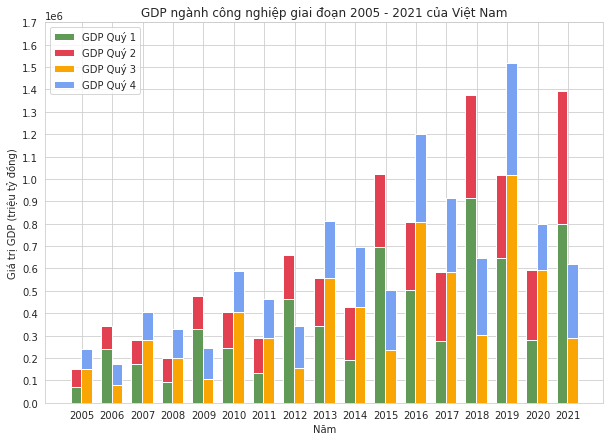

In [9]:
## Biểu đồ GDP ngành công nghiệp 2005 - 2021 theo 4 quý
import numpy as np
import matplotlib.pyplot as plt

years = list(map(str, range(2005, 2022)))

ind = np.arange(len(GDP_CongNghiep_Quy1)) 
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind - 0.2, GDP_CongNghiep_Quy1, width, color = '#619a56')
p2 = plt.bar(ind - 0.2, GDP_CongNghiep_Quy2, width, color = '#e34051', 
             bottom = GDP_CongNghiep_Quy1)
p3 = plt.bar(ind + 0.15, GDP_CongNghiep_Quy3, width, color = '#f9a504')
p4 = plt.bar(ind + 0.15, GDP_CongNghiep_Quy4, width, color = '#79a2f2',
              bottom = GDP_CongNghiep_Quy3)
plt.ylabel('Giá trị GDP (triệu tỷ đồng)')
plt.xlabel('Năm')
plt.title('GDP ngành công nghiệp giai đoạn 2005 - 2021 của Việt Nam')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 1800000 , 100000)) #Thiết lập giá trị trục y tùy ý vì biểu đồ biểu diễn cho cả 4 quý.
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('GDP Quý 1', 'GDP Quý 2', 'GDP Quý 3', 'GDP Quý 4'))

plt.show()

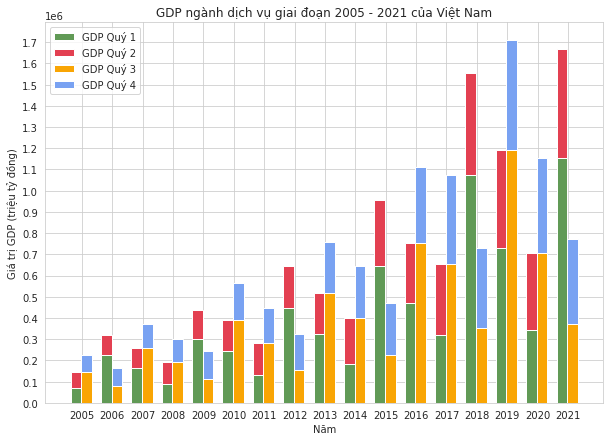

In [10]:
## Biểu đồ GDP ngành dịch vụ 2005 - 2021 theo 4 quý
import numpy as np
import matplotlib.pyplot as plt

years = list(map(str, range(2005, 2022)))

ind = np.arange(len(GDP_DichVu_Quy1)) 
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind - 0.2, GDP_DichVu_Quy1, width, color = '#619a56')
p2 = plt.bar(ind - 0.2, GDP_DichVu_Quy2, width, color = '#e34051', 
             bottom = GDP_DichVu_Quy1)
p3 = plt.bar(ind + 0.15, GDP_DichVu_Quy3, width, color = '#f9a504')
p4 = plt.bar(ind + 0.15, GDP_DichVu_Quy4, width, color = '#79a2f2',
              bottom = GDP_DichVu_Quy3)
plt.ylabel('Giá trị GDP (triệu tỷ đồng)')
plt.xlabel('Năm')
plt.title('GDP ngành dịch vụ giai đoạn 2005 - 2021 của Việt Nam')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 1800000 , 100000)) #Thiết lập giá trị trục y tùy ý vì biểu đồ biểu diễn cho cả 4 quý.
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('GDP Quý 1', 'GDP Quý 2', 'GDP Quý 3', 'GDP Quý 4'))

plt.show()


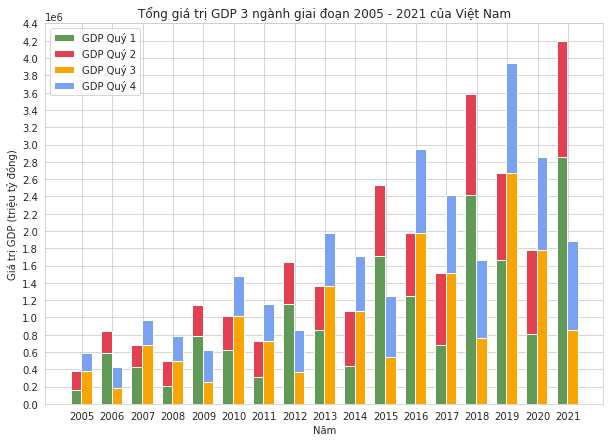

In [11]:
## Biểu đồ GDP tổng GDP các ngành 2005 - 2021 theo 4 quý
import numpy as np
import matplotlib.pyplot as plt

years = list(map(str, range(2005, 2022)))

ind = np.arange(len(GDP_Tong_Quy1)) 
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind - 0.2, GDP_Tong_Quy1, width, color = '#619a56')
p2 = plt.bar(ind - 0.2, GDP_Tong_Quy2, width, color = '#e34051', 
             bottom = GDP_Tong_Quy1)
p3 = plt.bar(ind + 0.15, GDP_Tong_Quy3, width, color = '#f9a504')
p4 = plt.bar(ind + 0.15, GDP_Tong_Quy4, width, color = '#79a2f2',
              bottom = GDP_Tong_Quy3)
plt.ylabel('Giá trị GDP (triệu tỷ đồng)')
plt.xlabel('Năm')
plt.title('Tổng giá trị GDP 3 ngành giai đoạn 2005 - 2021 của Việt Nam')
plt.xticks(ind, years)
plt.yticks(np.arange(0, 4500000 , 200000)) #Thiết lập giá trị trục y tùy ý vì biểu đồ biểu diễn cho cả 4 quý.
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('GDP Quý 1', 'GDP Quý 2', 'GDP Quý 3', 'GDP Quý 4'))

plt.show()

# Bước 4: Trích xuất đặc trưng

In [12]:
# Loại bỏ các dữ liệu không cần thiết.
# Ta thấy ô dữ liệu 6M và 9M là tổng lần lượt của
# 6M = Quý 1 + Quý 2
# 9M = 6M + Quý 3
# Cho nên ta có thể dự đoán dữ liệu các quý rồi 
# tự suy ra dữ liệu này, vậy ta sẽ bỏ các cột 6M, 9M.
# Loại bỏ các cột 6M/(năm)
TapDuLieu_GDP = TapDuLieu_GDP[TapDuLieu_GDP.columns.drop(
    list(TapDuLieu_GDP.filter(regex='6M')))]
# Loại bỏ các cột 9M/(năm)
TapDuLieu_GDP = TapDuLieu_GDP[TapDuLieu_GDP.columns.drop(
    list(TapDuLieu_GDP.filter(regex='9M')))]

Feature: 0, Score: -9589.00375
Feature: 1, Score: -6896.29974
Feature: 2, Score: -19637.76247
Feature: 3, Score: -14177.67035
Feature: 4, Score: 3507.77043
Feature: 5, Score: 4898.46774
Feature: 6, Score: 5546.27178
Feature: 7, Score: 0.67917
Feature: 8, Score: 0.71774
Feature: 9, Score: 1.54717
Feature: 10, Score: -1129.34176


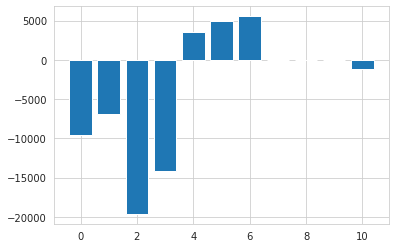

In [13]:
# Ranking feature
# Vì dữ liệu thuộc dạng time-series nên cần thêm một cột tượng trưng cho thời gian
# Copy dataframe ra để thêm cột nhằm tránh làm ảnh hưởng đến tập gốc.
TapDuLieu_GDP_W_Index = TapDuLieu_GDP.copy()
TapDuLieu_GDP_W_Index.loc['12'] = range(1, len(TapDuLieu_GDP_W_Index.T) + 1)

# Tách x,y với x là tham số đầu vào, y là tham số cần dự đoán
x = TapDuLieu_GDP_W_Index.T[['1','2','3','4','5','6','7','8',
                             '9', '10','12']].to_numpy()
y = TapDuLieu_GDP_W_Index.T['11'].to_numpy()

# Xếp hạng các đặc trưng dựa theo điểm số (thuật toán cây quyết định)
from sklearn.linear_model import LinearRegression
model =  LinearRegression()
model.fit(x,y)
importance = model.coef_
# tính toán độ quan trọng feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


Feature: 0, Score: -0.04850
Feature: 1, Score: -0.02639
Feature: 2, Score: -0.08203
Feature: 3, Score: -0.97484
Feature: 4, Score: 1.01816
Feature: 5, Score: 0.01685
Feature: 6, Score: -0.18060
Feature: 7, Score: -0.07367
Feature: 8, Score: 0.02004
Feature: 9, Score: 1.04004


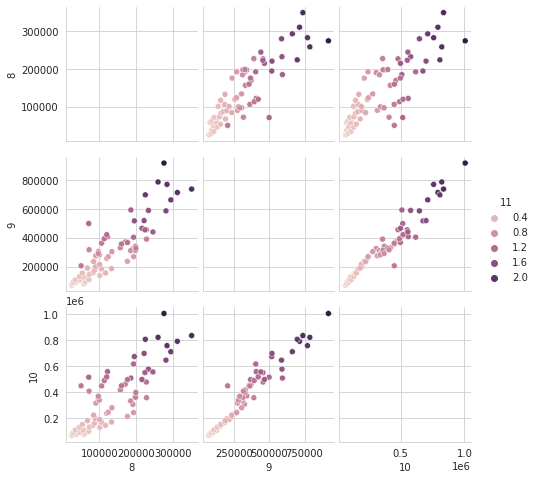

In [14]:
#Phân bố dữ liệu trên tập GDP VN
from seaborn.axisgrid import pairplot
# Gán nhãn cho các hàng

# Tách x,y với x là tham số đầu vào, y là tham số mục tiêu target
x = TapDuLieu_GDP.T[['1','2','3','4','5','6','7','8','9',
                          '10']].to_numpy()
y = TapDuLieu_GDP.T['11'].to_numpy() # Tổng GDP

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
x = sc.fit_transform(x)
y = sc.fit_transform(np.reshape(y, (-1, 2)))
y = y.flatten()
# Xếp hạng các đặc trưng dựa theo điểm số (thuật toán Hồi quy tuyến tính)
from sklearn.linear_model import LinearRegression
model =  LinearRegression()
model.fit(x,y)
importance = model.coef_
# tính toán độ quan trọng feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# Biểu diễn phân bố dữ liệu
import seaborn as sns
sns.pairplot(TapDuLieu_GDP.T, hue='11', vars=['8','9', '10'], height=2.25)

# Bước 5: Xây dựng mô hình dự đoán theo tỷ lệ 80/20

In [15]:
# Lấy ra cột 'Tổng GDP'
GDP_datas = TapDuLieu_GDP.T['11']
# Tạo ra mảng 2 chiều danh sách có số từ 0 -> n độ dài tập dữ liệu
# để tượng trưng cho thời gian.
times = list()
for i in range(len(GDP_datas)):
  times.append([i])
# Tạo ra mảng 2 chiều chứa giá trị Tổng GDP.
GDP = list()
for i in GDP_datas:
  GDP.append([i])
# Gián vào X, Y
X = times
Y = GDP


# Feature Engineering
# Chuẩn hoá dữ liệu
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)
Y = sc.fit_transform(Y)


from sklearn.model_selection import train_test_split
# Cắt tập dữ liệu ra làm 2 phần training(80%) và test(20%).
# shuffle=True để xáo trộn dữ liệu, tăng tính ngẫu nhiên cho mô hình
x_training, x_test, y_training, y_test = train_test_split(X,Y,test_size=0.20, 
                                                          random_state=0,
                                                          shuffle=True)

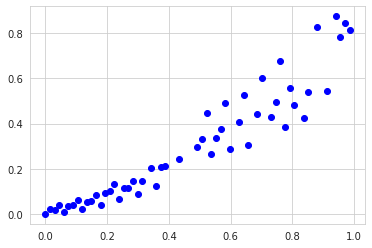

In [16]:
# Trực quan hoá tập Training
plt.plot(x_training, y_training, 'o', color='blue')

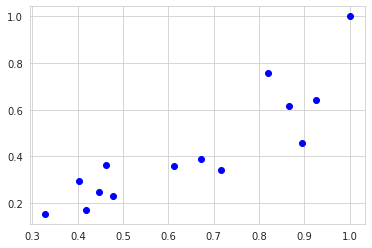

In [17]:
# Trực quan hoá tập Test
plt.plot(x_test, y_test, 'o', color='blue')

# Bước 6: Tiến hành dự đoán dữ liệu Tổng GDP

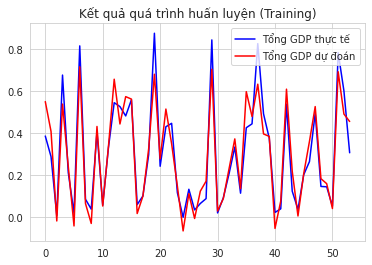

Mean Squared Error: 0.006690140415889107
Root Mean Squared Error: 0.08179327854957953
0.8929886740432367


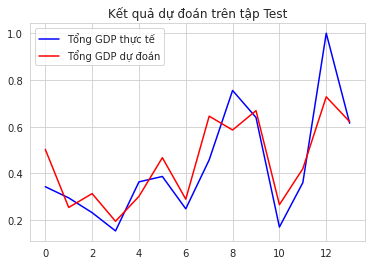

Mean Squared Error: 0.014196861598160332
Root Mean Squared Error: 0.11915058370885277
0.738947102330282


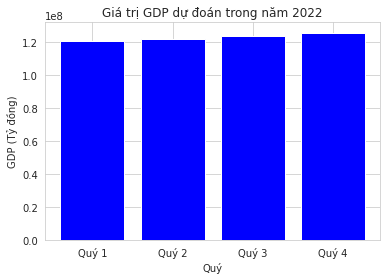

Dữ liệu dự đoán 4 Quý năm 2022
[1.20510827e+08 1.22282762e+08 1.24054697e+08 1.25826632e+08]


In [18]:
# Dự đoán bằng hồi quy tuyến tính
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_training, y_training)
pred_y = model.predict(x_training)
x_ax=range(len(x_training))
plt.plot(x_ax, y_training, lw=1.5, color="blue",
         label="Tổng GDP thực tế")
plt.plot(x_ax, pred_y, lw=1.5, color="red",
         label="Tổng GDP dự đoán")
plt.title("Kết quả quá trình huấn luyện (Training)")
plt.legend()
plt.show()

mse = mean_squared_error(y_training, pred_y)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_training, pred_y))

# Dự đoán
pred_y_test = model.predict(x_test)
x_ax=range(len(x_test))
plt.plot(x_ax, y_test, lw=1.5, color="blue",
         label="Tổng GDP thực tế")
plt.plot(x_ax, pred_y_test, lw=1.5, color="red",
         label="Tổng GDP dự đoán")
plt.title("Kết quả dự đoán trên tập Test")
plt.legend()
plt.show()

# Hiển thị sai số.
mse = mean_squared_error(y_test, pred_y_test)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_test, pred_y_test))
 

# Dự đoán Q1,Q2,Q3,Q4/2O22
data_len = len(X)
x_2022 = list()
for i in range(data_len,data_len+4):
  x_2022.append([i])

pred_y_2022 = model.predict(x_2022)
pred_y_2022 = sc.inverse_transform(pred_y_2022).flatten()
x_ax=range(len(x_2022))

tick_label = ['Quý 1', 'Quý 2', 'Quý 3', 'Quý 4']

plt.bar(x_ax, pred_y_2022, tick_label = tick_label,
        width = 0.8, color = 'blue')
plt.xlabel('Quý')
plt.ylabel('GDP (Tỷ đồng)')
plt.title('Giá trị GDP dự đoán trong năm 2022')
plt.show()
print("Dữ liệu dự đoán 4 Quý năm 2022")
np.set_printoptions(suppress=True)
print(np.array(pred_y_2022))

Text(0.5, 1.0, 'Đường thẳng (linear) trên tập Training')

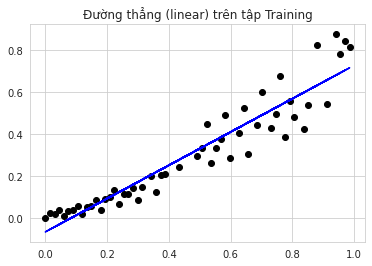

In [19]:
# Đường thẳng (linear) trên tập Training
plt.scatter(x_training, y_training,color='black')
plt.plot(x_training, pred_y,color='blue')

plt.title('Đường thẳng (linear) trên tập Training')

Text(0.5, 1.0, 'Đường thẳng (linear) trên tập Test')

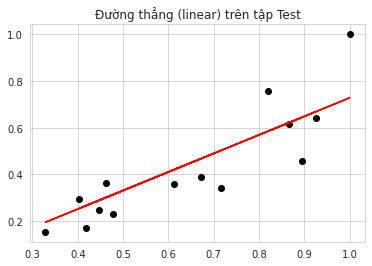

In [20]:
# Đường thẳng (linear) trên tập Test
plt.scatter(x_test, y_test,color='black')
plt.plot(x_test, pred_y_test,color='red')
plt.title('Đường thẳng (linear) trên tập Test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


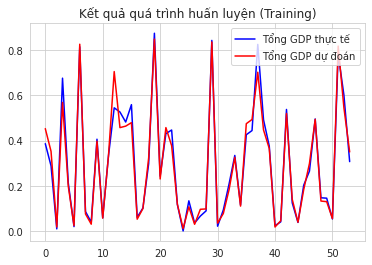

Mean Squared Error: 0.0018357479393515217
Root Mean Squared Error: 0.042845629174415464
0.9706365174868613


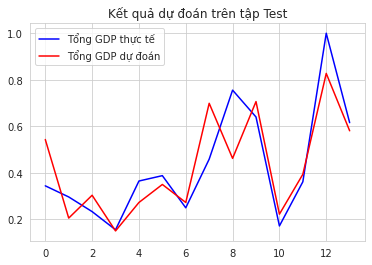

Mean Squared Error: 0.017613601849609604
Root Mean Squared Error: 0.13271624561299797
0.6761198403288567


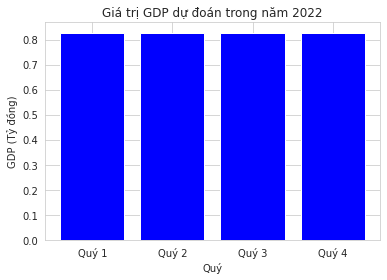

In [21]:
# Dự đoán bằng rừng ngẫu nhiên

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=20, random_state=0)
# Fit dữ liệu training vào model 
model.fit(x_training,y_training)

#huấn luyện
pred_y = model.predict(x_training)

x_ax=range(len(x_training))
plt.plot(x_ax, y_training, lw=1.5, color="blue", label="Tổng GDP thực tế")
plt.plot(x_ax, pred_y, lw=1.5, color="red", label="Tổng GDP dự đoán")
plt.title("Kết quả quá trình huấn luyện (Training)")
plt.legend()
plt.show()

mse = mean_squared_error(y_training, pred_y)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_training, pred_y))

# Dự đoán
pred_y_test = model.predict(x_test)
x_ax=range(len(x_test))
plt.plot(x_ax, y_test, lw=1.5, color="blue", label="Tổng GDP thực tế")
plt.plot(x_ax, pred_y_test, lw=1.5, color="red", label="Tổng GDP dự đoán")
plt.title("Kết quả dự đoán trên tập Test")
plt.legend()
plt.show()

# Hiển thị sai số.
mse = mean_squared_error(y_test, pred_y_test)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_test, pred_y_test))

# Dự đoán Q1,Q2,Q3,Q4/2O22
data_len = len(X)
x_2022 = list()
for i in range(data_len,data_len+4):
  x_2022.append([i])
# Dự đoán Q1,Q2,Q3,Q4/2O22
data_len = len(X)
x_2022 = list()
for i in range(data_len,data_len+4):
  x_2022.append([i])

pred_y_test = model.predict(x_2022)
x_ax=range(len(x_2022))

tick_label = ['Quý 1', 'Quý 2', 'Quý 3', 'Quý 4']
plt.bar(x_ax, pred_y_test, tick_label = tick_label,
        width = 0.8, color = 'blue')
plt.xlabel('Quý')
plt.ylabel('GDP (Tỷ đồng)')
plt.title('Giá trị GDP dự đoán trong năm 2022')
plt.show()


In [22]:
# Dự đoán bằng LSTM
# import thu vien
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
# Xay dung mo hinh
model = Sequential()
model.add(LSTM(units=128,input_shape=(len(x_training),1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mean_absolute_error',optimizer='adam')
# Huan luyen mo hinh
model.fit(np.asarray(x_training),y_training,epochs=100,batch_size=50,verbose=2)


Epoch 1/100
2/2 - 4s - loss: 0.3000 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.2874 - 23ms/epoch - 12ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2750 - 15ms/epoch - 7ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2637 - 16ms/epoch - 8ms/step
Epoch 5/100
2/2 - 0s - loss: 0.2512 - 15ms/epoch - 8ms/step
Epoch 6/100
2/2 - 0s - loss: 0.2399 - 16ms/epoch - 8ms/step
Epoch 7/100
2/2 - 0s - loss: 0.2323 - 16ms/epoch - 8ms/step
Epoch 8/100
2/2 - 0s - loss: 0.2198 - 14ms/epoch - 7ms/step
Epoch 9/100
2/2 - 0s - loss: 0.2095 - 15ms/epoch - 7ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1982 - 19ms/epoch - 9ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1911 - 19ms/epoch - 9ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1874 - 15ms/epoch - 8ms/step
Epoch 13/100
2/2 - 0s - loss: 0.1748 - 15ms/epoch - 8ms/step
Epoch 14/100
2/2 - 0s - loss: 0.1684 - 16ms/epoch - 8ms/step
Epoch 15/100
2/2 - 0s - loss: 0.1568 - 17ms/epoch - 9ms/step
Epoch 16/100
2/2 - 0s - loss: 0.1506 - 19ms/epoch - 9ms/step
Epoch 17/100
2/2 - 0s - loss: 0.154

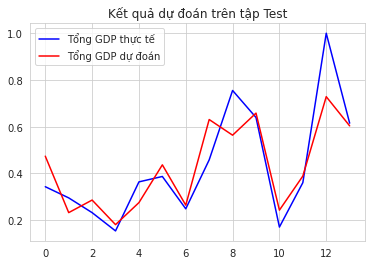

In [23]:
pred_y_test = model.predict(x_test)

x_ax=range(len(x_test))
plt.plot(x_ax, y_test, lw=1.5, color="blue", label="Tổng GDP thực tế")
plt.plot(x_ax, pred_y_test, lw=1.5, color="red", label="Tổng GDP dự đoán")
plt.title("Kết quả dự đoán trên tập Test")
plt.legend()
plt.show()


# **Thực hiện trên Sheet Dan_so_VN**
# Bước 1. Lấy dữ liệu sheet Dan_so_VN từ file

In [24]:
# Lấy dữ liệu dạng Dataframe của sheet Dan_so_VN từ file dữ liệu 
DATASET_DANSO = pd.read_excel('dataset_vongloai.xlsx', sheet_name='Dan_so_VN')



# Bước 2. Xử lý dữ liệu bị thiếu

In [27]:
# Xoá 2 cột chứa các nhãn dữ liệu như 'Nội dung', 'Đơn vị'.
TapDuLieu_DanSo = DATASET_DANSO.drop(['Nội dung', 'Đơn vị'], axis=1)
# Xoá các hàng có toàn giá trị rỗng (hàng "Dân số" và "Việc làm")
TapDuLieu_DanSo = TapDuLieu_DanSo.dropna(how='all')

# Xử lý giá trị bị thiếu.
# Thay thế giá trị bị thiếu bằng giá trị trung bình của 2 năm trước đó.
columnName2021 = TapDuLieu_DanSo.columns[-1]
TapDuLieu_DanSo[columnName2021] = np.where(TapDuLieu_DanSo[columnName2021].isnull(),
                                           TapDuLieu_DanSo.iloc[:,-3:-1].T.mean(),
                                           TapDuLieu_DanSo[columnName2021])
ThatNghiep = TapDuLieu_DanSo.T.iloc[:,8:9].T.iloc[:,15:]
# Lấy ra dữ liệu 'Thất nghiệp' năm 2005 -> 2021
So_That_Nghiep_2005_2021 = ThatNghiep.iloc[:1 , :].to_numpy()[0]
# Lấy ra dữ liệu 'Thất nghiệp' năm 1998 -> 2021
ThatNghiep = TapDuLieu_DanSo.T.iloc[:,8:9].T.iloc[:,8:].to_numpy()[0]
# Bieu dien du lieu thieu
# import seaborn as sns 
# %matplotlib inline
# sns.heatmap(data=TapDuLieu_DanSo.isnull(), yticklabels=False, 
# cbar =False, cmap = 'viridis')

# Bước 3: Trực quan hoá dữ liệu

Text(0.5, 1.0, 'Số dân thất nghiệp giai đoạn 2005 - 2021')

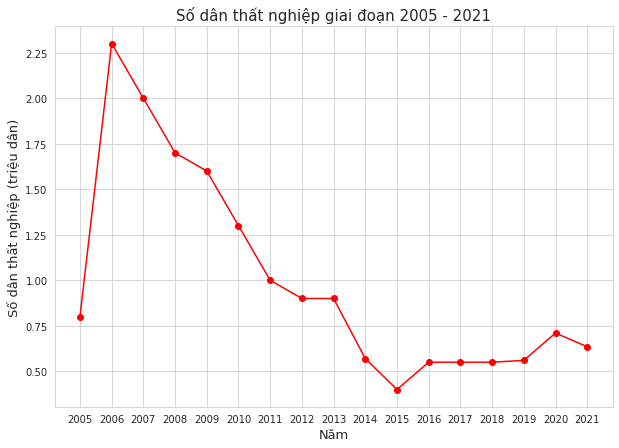

In [28]:
import numpy as np
import matplotlib.pyplot as plt

years = list(map(str, range(2005, 2022)))

fig = plt.subplots(figsize =(10, 7))
plt.plot(years, So_That_Nghiep_2005_2021, color='red', marker='o')
plt.ylabel('Số dân thất nghiệp (triệu dân)', fontsize = '13')
plt.xlabel('Năm', fontsize = '13')
plt.title('Số dân thất nghiệp giai đoạn 2005 - 2021', fontsize = '15')

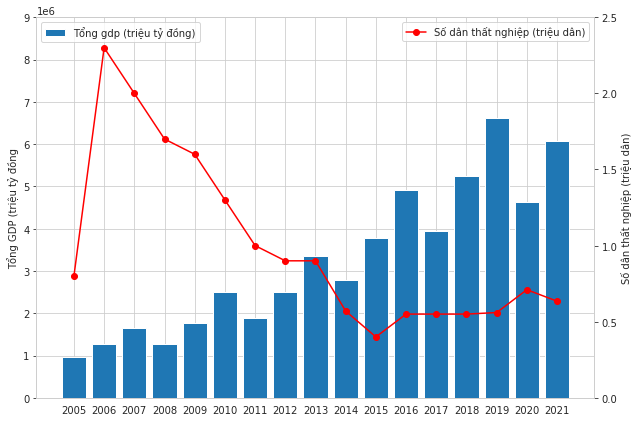

In [29]:
#Biểu đồ thể hiện mối tương quan giữa Tổng GDP và Số dân thất nghiệp giai đoạn 2005 - 2021
x_label = list(map(str, range(2005, 2022))) #trục x

ax_y1 = GDP_Tong_Nam #trục y trái (cần lấy dữ liệu của tổng GDP theo năm 
# (4 quý cộng lại) để đồng bộ với bên thất nghiệp => đưa ra được mối tương quan)
ax_y2 = So_That_Nghiep_2005_2021 #trục y phải

# Create figure and axis #1
fig, ax1 = plt.subplots(figsize =(10, 7))
# plot line chart on axis #1
ax1.bar(x_label, ax_y1) 
ax1.set_ylabel('Tổng GDP (triệu tỷ đồng')
ax1.set_ylim(0, 9000000)
ax1.legend(['Tổng gdp (triệu tỷ đồng)'], loc="upper left")
# set up the 2nd axis
ax2 = ax1.twinx()
# plot bar chart on axis #2
ax2.plot(x_label, ax_y2, color='red', marker='o')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Số dân thất nghiệp (triệu dân)')
ax2.set_ylim(0, 2.5)
ax2.legend(['Số dân thất nghiệp (triệu dân)'], loc="upper right")
plt.show()

# Bước 4: Trích xuất đặc trưng

Feature: 0, Score: -0.27133
Feature: 1, Score: 0.05954
Feature: 2, Score: 0.02415
Feature: 3, Score: 0.00408
Feature: 4, Score: 0.03843
Feature: 5, Score: -0.02681
Feature: 6, Score: 0.07132
Feature: 7, Score: -0.02553
Feature: 8, Score: -0.00037
Feature: 9, Score: 0.02896
Feature: 10, Score: 0.00623
Feature: 11, Score: -0.00861
Feature: 12, Score: 0.46328


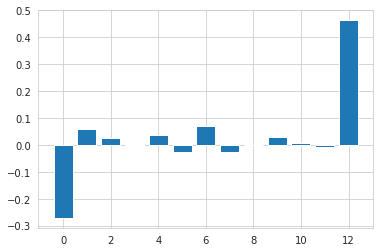

In [30]:
# Gán nhãn cho các hàng
TapDuLieu_DanSo.set_axis(['1', '2', '3','4','5','6','7','8','9',
                          '10','11','12','13','14'],
                          axis='index', inplace=True)
# Xoá các cột có giá trị rỗng NaN
TapDuLieu_DanSo_Temp = TapDuLieu_DanSo.T.dropna()


# Tách x,y với x là tham số đầu vào, y là tham số mục tiêu target
x = TapDuLieu_DanSo_Temp[['1','2','3','4','5','6','7','8',
                          '10','11','12','13','14']].to_numpy()
y = TapDuLieu_DanSo_Temp['9'].to_numpy() # Thất nghiệp

# Xếp hạng các đặc trưng dựa theo điểm số (thuật toán Hồi quy tuyến tính)
from sklearn.linear_model import LinearRegression
model =  LinearRegression()
model.fit(x,y)
importance = model.coef_
# tính toán độ quan trọng feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: -0.27133
Feature: 1, Score: 0.05954
Feature: 2, Score: 0.02415
Feature: 3, Score: 0.00408
Feature: 4, Score: 0.03843
Feature: 5, Score: -0.02681
Feature: 6, Score: 0.07132
Feature: 7, Score: -0.02553
Feature: 8, Score: -0.00037
Feature: 9, Score: 0.02896
Feature: 10, Score: 0.00623
Feature: 11, Score: -0.00861
Feature: 12, Score: 0.46328


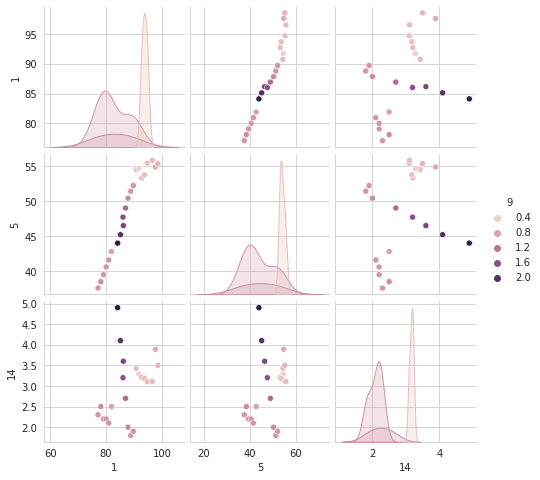

In [31]:
#Phân bố dữ liệu trên tập Dân số VN
from seaborn.axisgrid import pairplot
# Gán nhãn cho các hàng
TapDuLieu_DanSo.set_axis(['1', '2', '3','4','5','6','7','8','9',
                          '10','11','12','13','14'],
                          axis='index', inplace=True)
# Xoá các cột có giá trị rỗng NaN
TapDuLieu_DanSo_Temp = TapDuLieu_DanSo.T.dropna()


# Tách x,y với x là tham số đầu vào, y là tham số mục tiêu target
x = TapDuLieu_DanSo_Temp[['1','2','3','4','5','6','7','8',
                          '10','11','12','13','14']].to_numpy()
y = TapDuLieu_DanSo_Temp['9'].to_numpy() # Thất nghiệp

# Xếp hạng các đặc trưng dựa theo điểm số (thuật toán Hồi quy tuyến tính)
from sklearn.linear_model import LinearRegression
model =  LinearRegression()
model.fit(x,y)
importance = model.coef_
# tính toán độ quan trọng feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# Biểu diễn phân bố dữ liệu
import seaborn as sns
sns.pairplot(TapDuLieu_DanSo_Temp, hue='9', vars=['1','5','14'], height=2.25)

# Bước 5: Xây dựng mô hình dự đoán theo tỷ lệ 80/20

In [32]:
# Tạo ra mảng 2 chiều danh sách có số từ 0 -> n độ dài tập dữ liệu
# để tượng trưng cho thời gian.
times = list()
for i in range(len(ThatNghiep)):
  times.append([i])
# Tạo ra mảng 2 chiều chứa giá trị Thất nghiệp.
TN = list()
for i in ThatNghiep:
  TN.append([i])
# Gián vào X, Y
X = times
Y = TN

# Feature Engineering
# Chuẩn hoá dữ liệu
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)
Y = sc.fit_transform(Y)


from sklearn.model_selection import train_test_split
# Cắt tập dữ liệu ra làm 2 phần training(80%) và test(20%).
# shuffle=True để xáo trộn dữ liệu, tăng tính ngẫu nhiên cho mô hình
x_training, x_test, y_training, y_test = train_test_split(X,Y,test_size=0.20, 
                                                          random_state=0,
                                                          shuffle=True)

# Bước 6: Tiến hành dự đoán Thất nghiệp

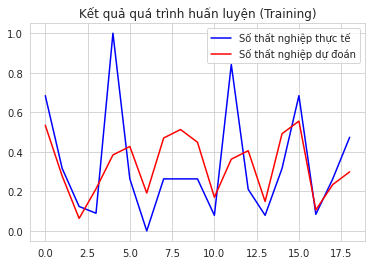

Mean Squared Error: 0.05185690412339592
Root Mean Squared Error: 0.2277211104034844
0.3039299070523681


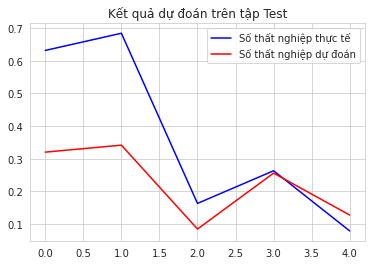

Mean Squared Error: 0.044587123075393545
Root Mean Squared Error: 0.2111566316159489
0.27120153266304425


In [33]:
# Dự đoán bằng hồi quy tuyến tính
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_training, y_training)
pred_y = model.predict(x_training)
x_ax=range(len(x_training))
plt.plot(x_ax, y_training, lw=1.5, color="blue",
         label="Số thất nghiệp thực tế")
plt.plot(x_ax, pred_y, lw=1.5, color="red",
         label="Số thất nghiệp dự đoán")
plt.title("Kết quả quá trình huấn luyện (Training)")
plt.legend()
plt.show()

mse = mean_squared_error(y_training, pred_y)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_training, pred_y))

# Dự đoán
pred_y_test = model.predict(x_test)
x_ax=range(len(x_test))
plt.plot(x_ax, y_test, lw=1.5, color="blue",
         label="Số thất nghiệp thực tế")
plt.plot(x_ax, pred_y_test, lw=1.5, color="red",
         label="Số thất nghiệp dự đoán")
plt.title("Kết quả dự đoán trên tập Test")
plt.legend()
plt.show()

# Hiển thị sai số.
mse = mean_squared_error(y_test, pred_y_test)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)
print(r2_score(y_test, pred_y_test))


Text(0.5, 1.0, 'Đường thẳng (linear) trên tập Training')

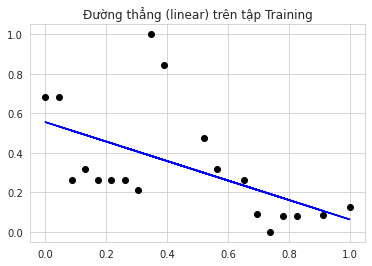

In [34]:
# Đường thẳng (linear) trên tập Training
plt.scatter(x_training, y_training,color='black')
plt.plot(x_training, pred_y,color='blue')

plt.title('Đường thẳng (linear) trên tập Training')

Text(0.5, 1.0, 'Đường thẳng (linear) trên tập Test')

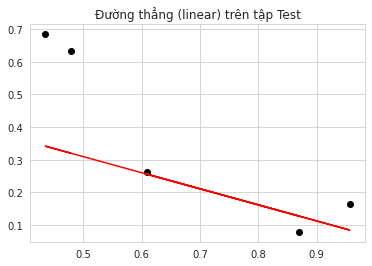

In [35]:
# Đường thẳng (linear) trên tập Test
plt.scatter(x_test, y_test,color='black')
plt.plot(x_test, pred_y_test,color='red')
plt.title('Đường thẳng (linear) trên tập Test')

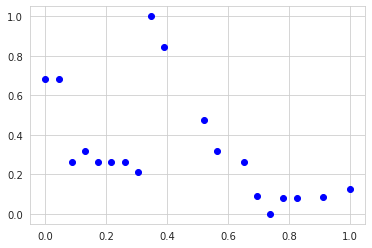

In [36]:
# Trực quan hoá tập Training
plt.plot(x_training, y_training, 'o', color='blue')

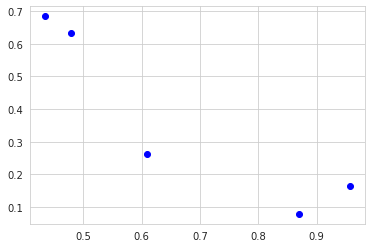

In [37]:
# Trực quan hoá tập Test
plt.plot(x_test, y_test, 'o', color='blue')